# Search With Inconsistent Heuristic

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
%matplotlib inline

### Grid map representation 

Square grid map class represents the environment for our moving agent

- width -- the number of columns in the grid
- height -- the number of rows in the grid
- cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked

In [2]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]


    def get_neighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 4-connected (i.e. only moves into cardinal directions are allowed)
        '''   
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]

        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

    def get_size(self):
        return (self._height, self._width)


Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In case of 4-connected grid it is always equal to 1. However if the connectivity of a grid exceeds 4 the cost of a transition may vary.

Recall that in this lab we assume 4-connected grid, i.e. only cardinal moves are allowed.

In [3]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves between cells
    '''
    if abs(i1 - i2) + abs(j1 - j2) == 1: #cardinal move
        return 1
    else:
        raise Exception('Trying to compute the cost of non-supported move! ONLY cardinal moves are supported.')


### Search Node Representation



In [4]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    '''

    def __init__(self, i, j, g = 0, h = 0, F = None, parent = None, k = 0):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        self.k = k
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
    
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)


    def __lt__(self, other): 
        '''
        Comparison betweeb self and other. Returns is self < other (self has higher priority).
        
        In this lab we limit ourselves to cardinal-only uniform-cost moves (cost = 1) and 
        Manhattan distance for A*, so g, h, f-values are integers, so the comparison is straightforward
        '''
        return self.F < other.F or ((self.F == other.F) and (self.h < other.h))\
        or ((self.F == other.F) and (self.h == other.h) and (self.k > other.k))

    def get_pos(self):
        return self.i, self.j


### Visualization

In [5]:
def draw(grid_map, start = None, goal = None, path = None, nodes_opened = None, nodes_expanded = None, nodes_reexpanded = None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and opened, expanded and reexpanded cells.
    '''
    k = 5
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodes_opened is not None:
        for node in nodes_opened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodes_expanded is not None:
        for node in nodes_expanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)

    if nodes_reexpanded is not None:
        for node in nodes_reexpanded:
                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(255, 145, 146), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (grid_map.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (grid_map.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (grid_map.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()


Example of the visualization

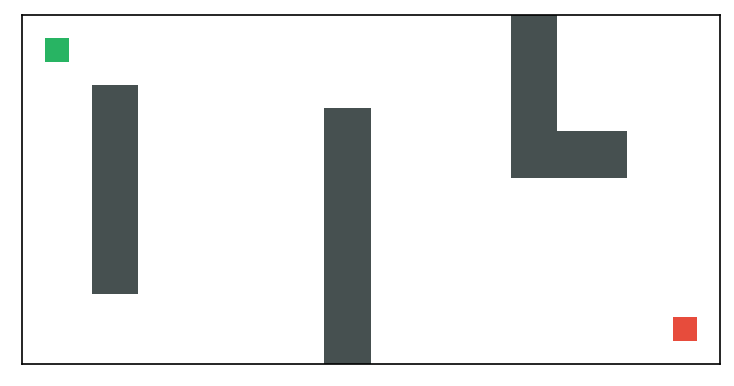

In [6]:
height = 15
width = 30
map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

test_map = Map()
test_map.read_from_string(map_str, width, height)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

### Implementing OPEN and CLOSED
Efficient implementation of OPEN and CLOSED is crucial for any search algorithm. Below you may find basic implementations that use lists to store the elements of OPEN and CLOSED. This is not very efficient. Your task is to create your own implementations.

It's a good idea to modify CLOSED first (as it is pretty straghtforward to do so). Then check that everything is OK, i.e. the search algorithms work faster and the result is correct. Then proceed to modifying OPEN (which is not that trivial as might seem).

PS: You may wish to add additional fields, methods, method-arguments etc. to your implementations.


In [7]:
class OpenBase:

    def __init__(self):
        pass

    def __len__(self):
        pass

    def __iter__(self):
        pass

    def is_empty(self):
        '''
        is_empty should inform whether the OPEN is exhausted or not in the former case the search main loop should be interrupted
        '''
        pass

    def add_node(self, node, *args):
        '''
        add_node is the method that puts (e.g. inserts or updates) the node to OPEN
        When implementing it do not forget to handle all possible cases:
         - node already in OPEN but the new g-value is better;
         - node already in OPEN but the new g-value is worse;
         - node is not in OPEN yet.
        '''
        pass

    def get_best_node(self, *args):
        '''
        get_best_node is the method that 
         i) finds the best node, i.e. the one with the lowest f-value (f=g+h) (for Dijkstra h=0),
         ii) removes it from OPEN and 
         iii) returns it
        '''
        pass


In [8]:
import heapq

class YourOpen (OpenBase):
    
    def __init__(self):
        self.heap = []
        self.nodes = {}
    
    def __iter__(self):
        return iter(self.nodes.values())
    
    def __len__(self):
        return len(self.nodes)

    def is_empty(self):
        return len(self) == 0

    def add_node(self, node: Node, *args):
        pos = node.get_pos()
        if pos in self.nodes:
            if self.nodes[pos].g <= node.g:
                return
        self.nodes[pos] = node
        heapq.heappush(self.heap, node)

    def get_best_node(self, *args):
        while True:
            best = self.heap[0]
            heapq.heappop(self.heap)
            pos = best.get_pos()
            if pos in self.nodes:
                break
        del self.nodes[pos]
        return best

In [9]:
class ClosedBase:

    def __init__(self):
        pass

    def __iter__(self):
        pass
    
    def __len__(self):
        pass
    
    def add_node(self, item):
        '''
        add_node is the method that inserts the node to CLOSED
        '''
        pass

    def was_expanded(self, item):
        '''
        was_expanded is the method that checks if a node has been expanded
        '''
        pass



In [10]:
class YourClosed (ClosedBase):

    def __init__(self):
        self.nodes = {}

    def __iter__(self):
        return iter(self.nodes.values())
    
    def __len__(self):
        return len(self.nodes)

    def add_node(self, item):
        self.nodes[item.get_pos()] = item

    def was_expanded(self, item):
        return item.get_pos() in self.nodes



### Validating the results


In [11]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length


`simple_test` tests the pathfing algorithm on a single simple instance. Returns same result as search function. Both tests assume that the search function fits the following pattern:

`search(task_map, s.i, s.j, g.i, g.j, *optional arguments*) -> (path_found, last_state, steps, nodes_created, discovered, expanded, [reexpanded])`, where

- `task_map` -- grid
- `s.i, s.j` -- (i,j) coordinates of the start cell
- `g.i, g.j` -- (i,j) coordinates of the goal cell
- `*optional arguments*` -- additional parameters of the search function, passed with `*args`. Example of additional parameters you can see at Dijkstra and A* functions
- `path_found` -- `True` if path was found, `False` otherwise
- `last_state` -- last state of the path. `None` if path was not found
- `steps` -- the number of search steps
- `nodes_created` -- the number of nodes, which were created and stored during the search process 
- `discovered` -- iterable collection of discovered nodes
- `expanded` --  iterable collection of expanded nodes
- `reexpanded` -- iterable collection of reexpanded nodes (single node for single reexpanded cell). Optional for case of A* with reexpansions  


In [12]:
from random import randint


def simple_test(search_func, task, *args):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    lengths = [36, 30, 30, 21, 28, 24, 32, 27, 42, 23, 35, 37, 23, 26, 40, 36, 42, 28, 44, 36, 38, 29, 33, 42, 44]

    if (task is None) or not (0 <= task < 25):
        task = randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
        number_of_steps = result[2]
        nodes_created = result[3]
        if result[0]:
            path = make_path(result[1])
            correct = int(path[1])  == int(length)
            draw(task_map, start, goal, path[0], *result[4:])
            print("Path found! Length: " + str(path[1]) + \
                ". Nodes created: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps) + ". Correct: " + str(correct))
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


## A* Algorithm

In [13]:
def manhattan_distance(i1, j1, i2, j2):
     return abs(int(i1) - int(i2)) + abs(int(j1) - int(j2))


In [14]:
def astar(grid_map: Map, start_i, start_j, goal_i, goal_j, heuristic_func = None, open_type = YourOpen, closed_type = YourClosed):
    
    OPEN = open_type()
    CLOSED = closed_type()
    steps = 0
    nodes_created = 0

    h = heuristic_func(start_i, start_j, goal_i, goal_j)
    OPEN.add_node(Node(start_i, start_j, h=h))
    nodes_created += 1

    while not OPEN.is_empty():
        steps += 1
        v = OPEN.get_best_node()
        CLOSED.add_node(v)
        if v.get_pos() == (goal_i, goal_j):
            return True, v, steps, nodes_created, OPEN, CLOSED
        for nxt_i, nxt_j in grid_map.get_neighbors(v.i, v.j):
            cost = compute_cost(v.i, v.j, nxt_i, nxt_j)
            h = heuristic_func(nxt_i, nxt_j, goal_i, goal_j)
            nxt_node = Node(nxt_i, nxt_j, v.g + cost, h, parent=v)
            nodes_created += 1
            if not CLOSED.was_expanded(nxt_node):
                OPEN.add_node(nxt_node)

    return (False, None, steps, nodes_created, OPEN, CLOSED)


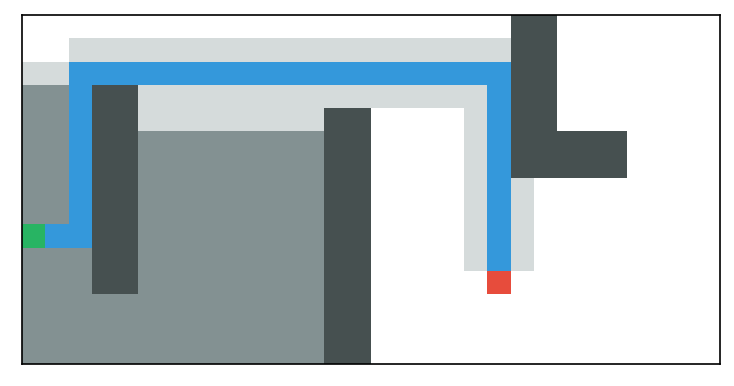

Path found! Length: 36. Nodes created: 537. Number of steps: 150. Correct: True
Wall time: 59.7 ms


In [15]:
%time res = simple_test(astar, 0, manhattan_distance, YourOpen, YourClosed)

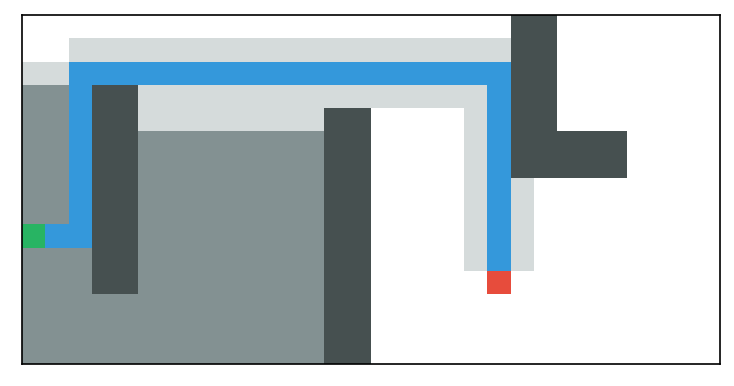

Path found! Length: 36. Nodes created: 537. Number of steps: 150. Correct: True


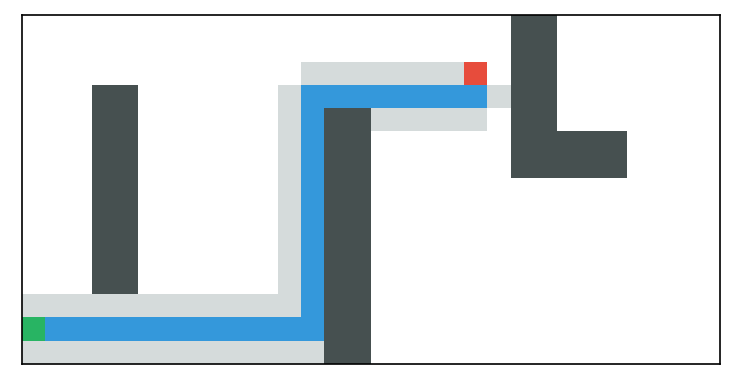

Path found! Length: 30. Nodes created: 108. Number of steps: 31. Correct: True


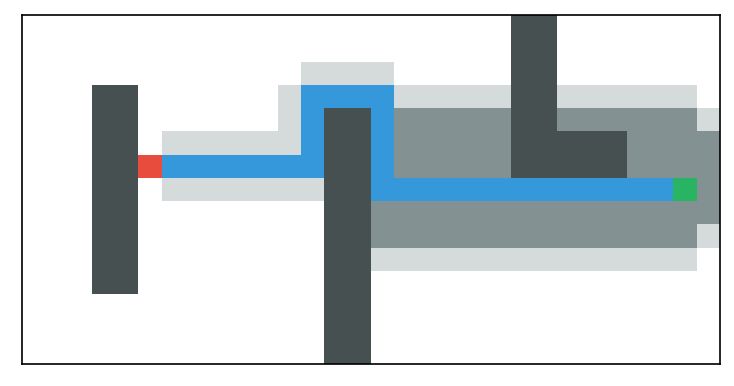

Path found! Length: 30. Nodes created: 328. Number of steps: 90. Correct: True


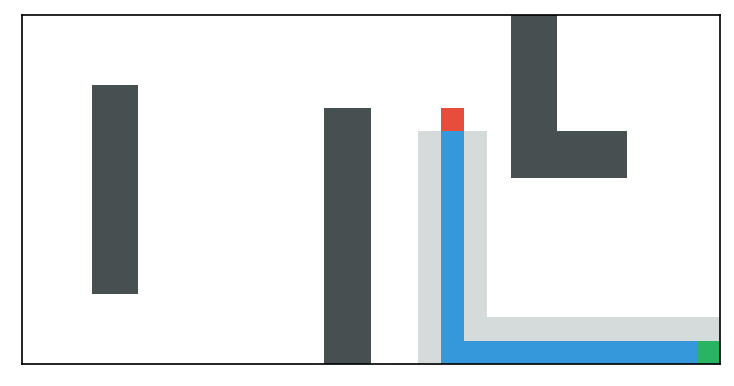

Path found! Length: 21. Nodes created: 72. Number of steps: 22. Correct: True


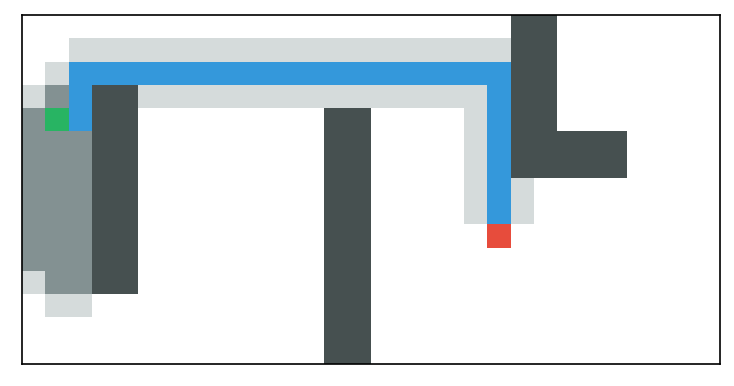

Path found! Length: 28. Nodes created: 178. Number of steps: 51. Correct: True


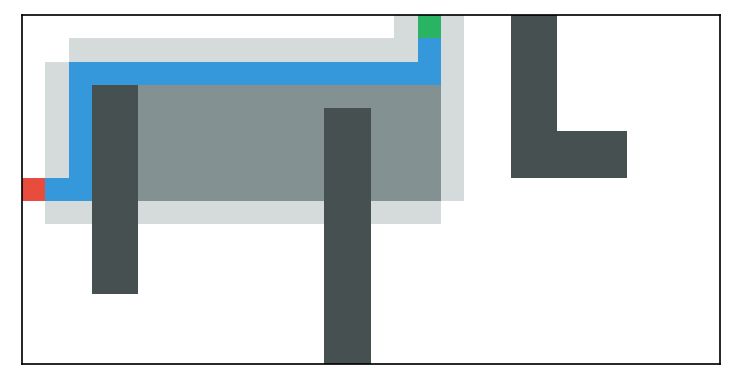

Path found! Length: 24. Nodes created: 302. Number of steps: 82. Correct: True


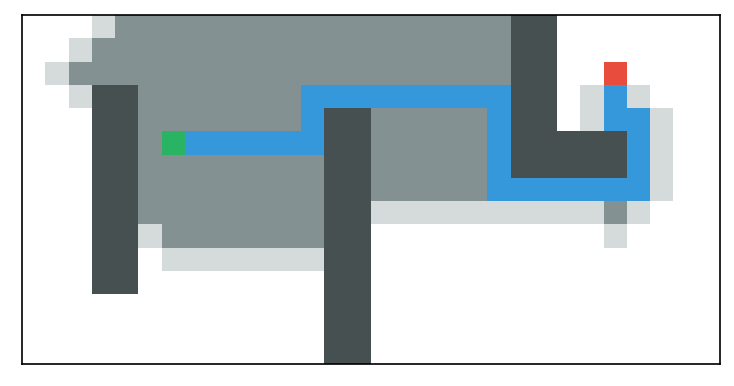

Path found! Length: 32. Nodes created: 561. Number of steps: 154. Correct: True


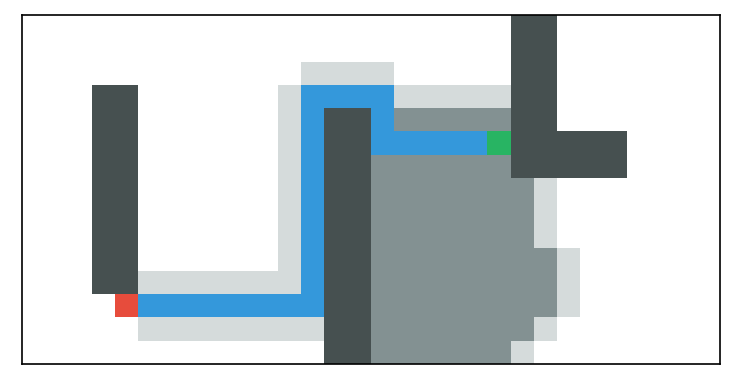

Path found! Length: 27. Nodes created: 353. Number of steps: 97. Correct: True


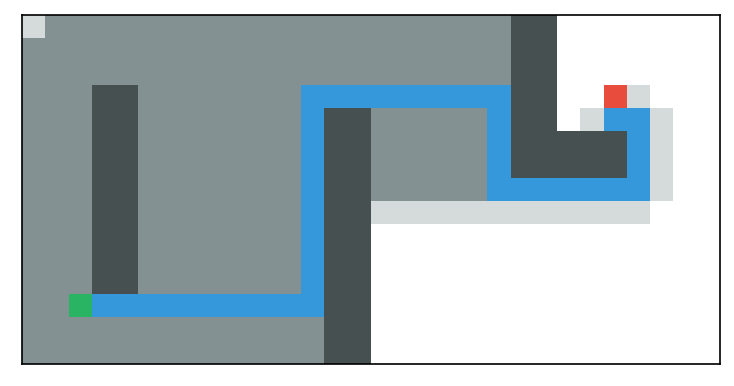

Path found! Length: 42. Nodes created: 868. Number of steps: 243. Correct: True


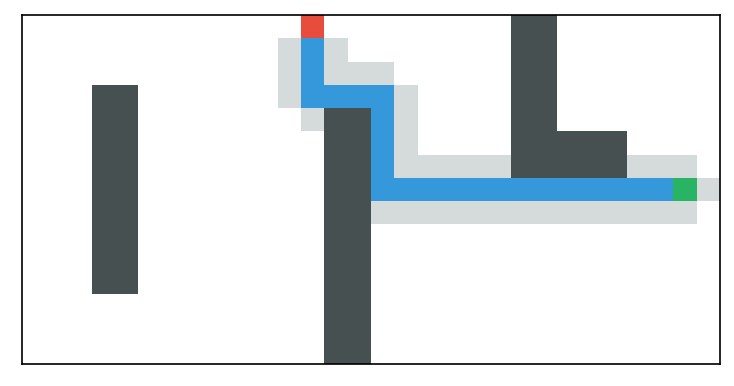

Path found! Length: 23. Nodes created: 82. Number of steps: 24. Correct: True


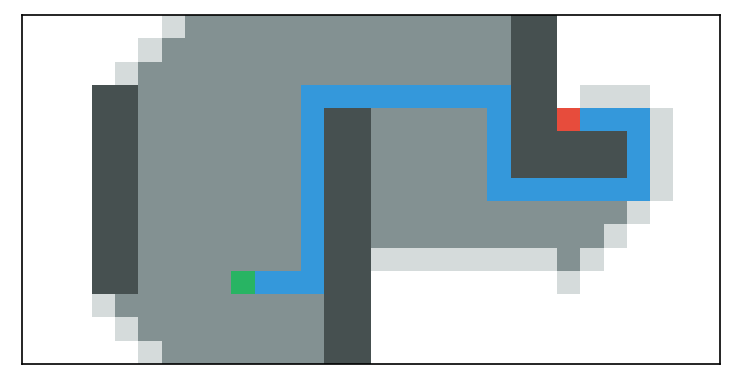

Path found! Length: 35. Nodes created: 759. Number of steps: 207. Correct: True


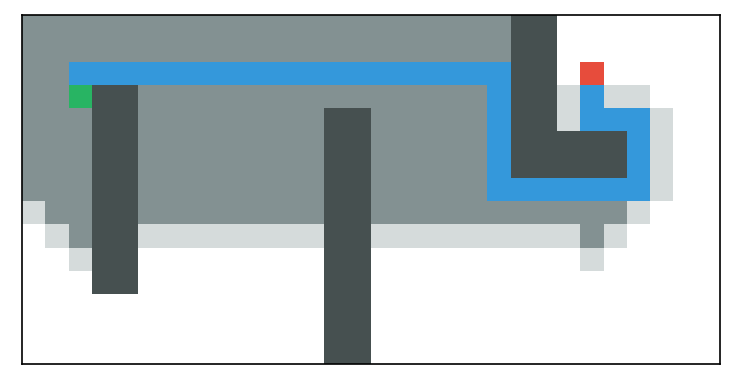

Path found! Length: 37. Nodes created: 669. Number of steps: 186. Correct: True


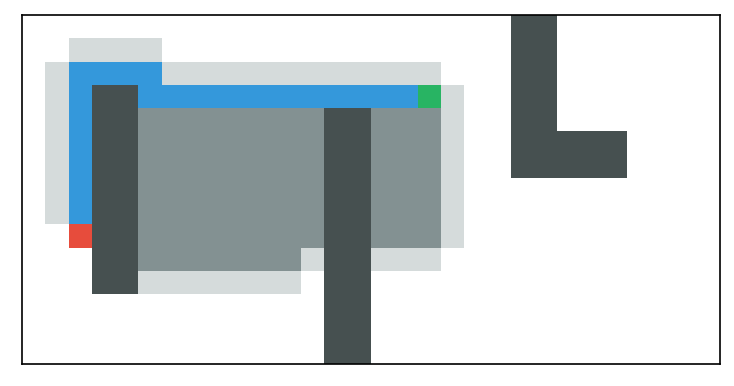

Path found! Length: 23. Nodes created: 355. Number of steps: 97. Correct: True


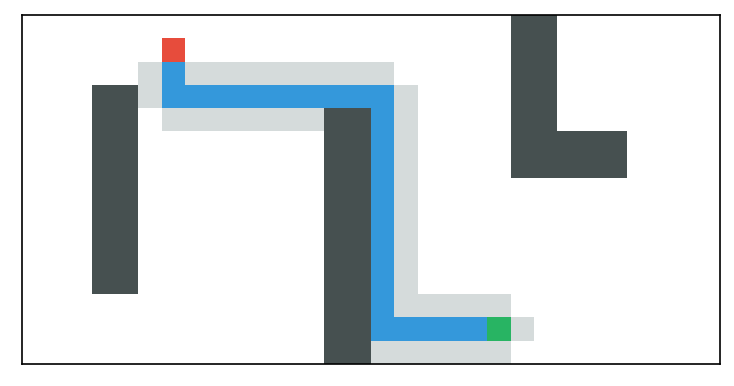

Path found! Length: 26. Nodes created: 93. Number of steps: 27. Correct: True


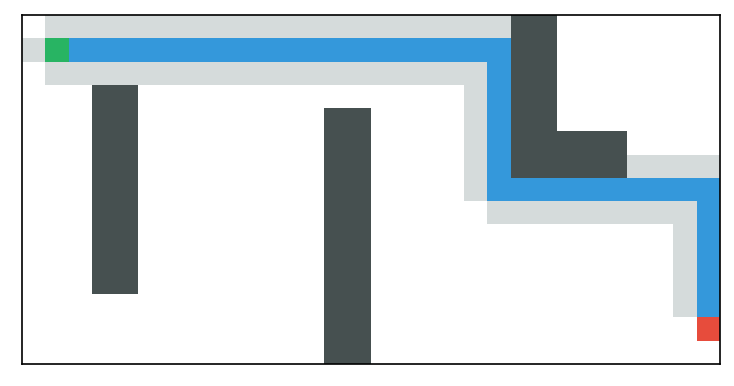

Path found! Length: 40. Nodes created: 144. Number of steps: 41. Correct: True


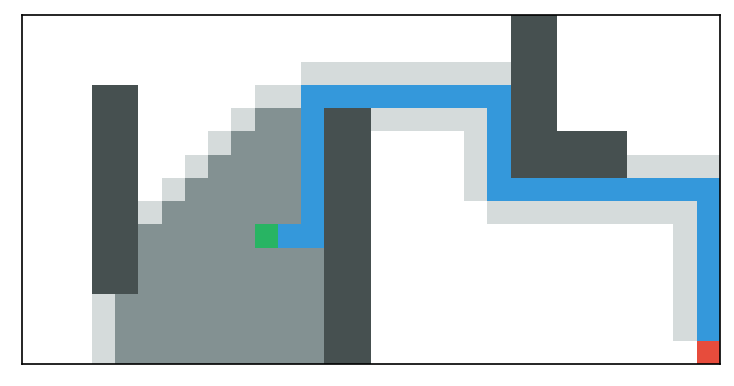

Path found! Length: 36. Nodes created: 375. Number of steps: 105. Correct: True


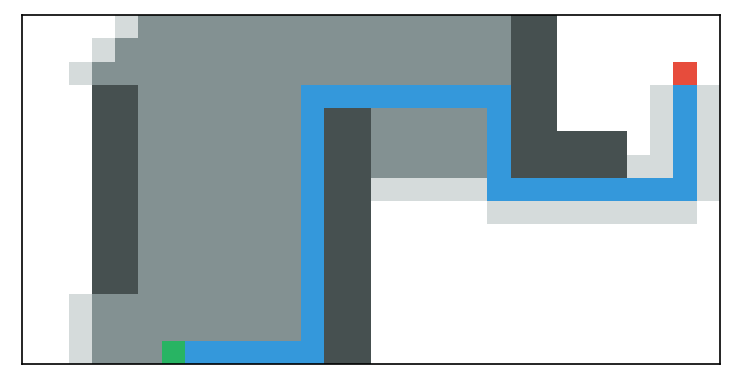

Path found! Length: 42. Nodes created: 702. Number of steps: 193. Correct: True


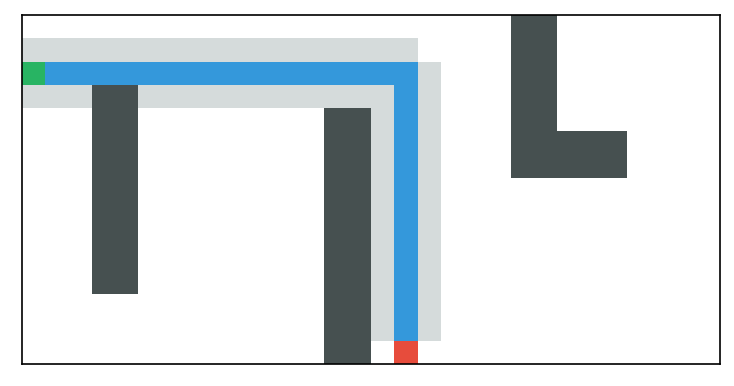

Path found! Length: 28. Nodes created: 110. Number of steps: 29. Correct: True


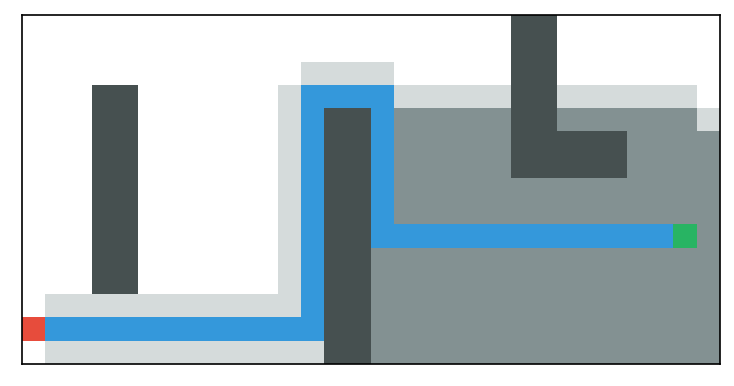

Path found! Length: 44. Nodes created: 647. Number of steps: 178. Correct: True


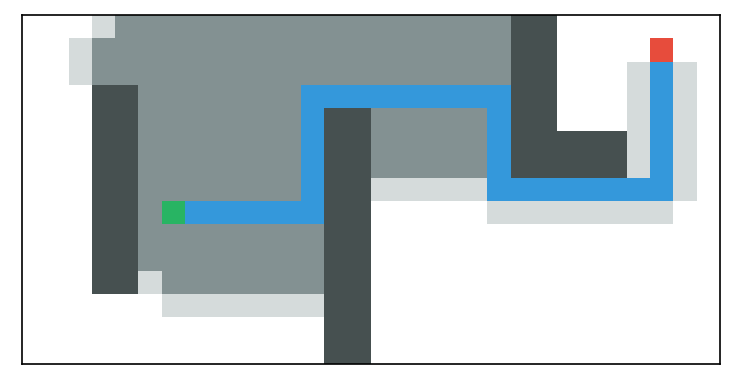

Path found! Length: 36. Nodes created: 601. Number of steps: 164. Correct: True


In [16]:
for i in range(20):
    simple_test(astar, i, manhattan_distance, YourOpen, YourClosed)

## Inconsistent Heuristic Function

In [17]:
def inconsistent_heuristic(i1, j1, i2, j2):
    '''
    A basic not consistent heuristic function for simple_test map, that based on manhattan_distance multiplied by coefficient from 0 to 1. 
    Such range of coefficient ensures that the function does not overestimate the true spacing between cells, but makes it inconsistent.
    '''
    coef = [[0.32831655869667997, 0.02602781916714625, 0.32602955554375024, 0.06234916377268629, 0.35295444407424986, 0.4399763742097014, 0.46962919934270825, 0.16144646916333383, 0.04178119522641788, 0.3615984917894237, 0.1663930560924083, 0.1556095515496247, 0.023184930929364966, 0.2417350062696204, 0.14690725879414124, 0.020766506492569392, 0.006869319632844428, 0.3824707325836774, 0.3912138018969597, 0.201089314826286, 0.2884529835910057, 0.4795063591225301, 0.10333745819385776, 0.33834740384881046, 0.08447318037398205, 0.010754818060922267, 0.23611557024543672, 0.3629237250718168, 0.3678390854556626, 0.0006988268075135973], [0.17081730580243898, 0.42815946938275257, 0.024739567784460792, 0.2384247988728579, 0.4480895478056663, 0.43049105235702034, 0.3649923418701008, 0.08565497107344322, 0.4069843090234916, 0.32498662639563125, 0.2826508716412064, 0.1973909468425717, 0.4125632682759354, 0.29608357889521686, 0.04662324665294576, 0.32915442809479756, 0.08864327609387218, 0.4643067499890007, 0.3963962928888365, 0.0402016795594885, 0.2954060455404461, 0.38728059734093084, 0.19527308273361277, 0.3170835313741325, 0.3294472639012368, 0.302480192507245, 0.23827669438631033, 0.11079177021531394, 0.43438329910834717, 0.1465810756285223], [0.27794966579449815, 0.4958689976703051, 0.2367219131177683, 0.11742295670949221, 0.36177711351980735, 0.20951533058916783, 0.3063171220477524, 0.2728786620098217, 0.2959417227081334, 0.4209509633145379, 0.32077674238174947, 0.3532802742140129, 0.10159841447119167, 0.2625386536587789, 0.23272086429640437, 0.4119533662959103, 0.46798257469700083, 0.43826446882497194, 0.19412482734352465, 0.41570757993008334, 0.09194411485967935, 0.3374939455246143, 0.48950601103738256, 0.045810930194507216, 0.4681125020725993, 0.44697056880494346, 0.2974354458736584, 0.09661345183840903, 0.10179352117821233, 0.4984785204236554], [0.31651770176123994, 0.1993533617539145, 0.05498519883408326, 0.407507877609872, 0.20989800681581555, 0.23189729215295218, 0.47632912929283583, 0.44082813541052335, 0.37641111507987496, 0.3705325659565917, 0.27114709146390303, 0.2749722526417302, 0.17510400455600839, 0.24928453580259324, 0.26706843358187277, 0.20003119594515434, 0.48517351349738025, 0.358737443887516, 0.014499586935358744, 0.3695458096843226, 0.4139350643060239, 0.2637524793563651, 0.4333072493320588, 0.3866231497861453, 0.11568118966984908, 0.3866545361237745, 0.37255358968718705, 0.4536093231053632, 0.028298598616680992, 0.3843631281995794], [0.022936654540356094, 0.25692869680419306, 0.19114439827311597, 0.003914578307714578, 0.39772983606753926, 0.48127846041963485, 0.15484631395861503, 0.17908081898759592, 0.3090343519006113, 0.10462195950165115, 0.25317932866238774, 0.2009237282348788, 0.09359760036914322, 0.40364807856529455, 0.055891331785010545, 0.16337863324659613, 0.2691732384510364, 0.07486676107970769, 0.2314626630913364, 0.12306319045683534, 0.11356274675838057, 0.4599953194126375, 0.47460828131193905, 0.005834864826164188, 0.23612309430392764, 0.24485991819861713, 0.3434512516138732, 0.0016997052470916763, 0.4652005711931813, 0.10897558145101721], [0.4177181343966487, 0.09069818058411377, 0.2583378454221766, 0.2926980136879932, 0.26099645390826415, 0.18663359178918487, 0.16494752746012747, 0.3045066233089356, 0.030327171547539444, 0.24211821728616623, 0.21020550645343966, 0.3254991411698671, 0.04408967134538244, 0.18516527405991012, 0.226869664228824, 0.35029312220233516, 0.48700545978262755, 0.03419912948567566, 0.024283669463694313, 0.47335552232710487, 0.42404061979262847, 0.33043653199901163, 0.2035393825503235, 0.14279930595010976, 0.41988656885759507, 0.41249205988560517, 0.2862977326301444, 0.09366895332179775, 0.45524177915388536, 0.3173102222994394], [0.3479789803766766, 0.12562823926040556, 0.0721693670613146, 0.20546695912853757, 0.307432280661857, 0.15892258220830824, 0.3307928002878911, 0.4282389396286852, 0.31895994328404403, 0.015396070429757436, 0.41000311890122926, 0.21378824993375084, 0.008321262258760398, 0.4013416238710389, 0.11679565203646447, 0.39068214734907575, 0.02756563930087408, 0.0864279961796352, 0.06269745872485477, 0.44744087209088734, 0.08554027053671065, 0.25808842487838324, 0.3792373276058973, 0.26592827742194886, 0.13573466401440826, 0.4221104642788447, 0.06931890321196982, 0.4811769460605059, 0.07160913132384294, 0.2209815674928729], [0.047394725493421, 0.3254532739454676, 0.4889474568782018, 0.4884912459734134, 0.08899137271945917, 0.0775187529515095, 0.036745730507082686, 0.46210733564619816, 0.46448504074512464, 0.27123073573140677, 0.4553565473284872, 0.37035303634205086, 0.4934678606962635, 0.019661386910363066, 0.17099346676189248, 0.4392004470387358, 0.3464041754911792, 0.40975379020666525, 0.0745008466846444, 0.059201027939790096, 0.30856935195187274, 0.10104120745569212, 0.05457760583206317, 0.3965116846153794, 0.05947587542297933, 0.05997362484679519, 0.21266215363724134, 0.3253803194397574, 0.09565183795743193, 0.05053070702793], [0.21016734098859463, 0.20770958451528826, 0.43514843066138503, 0.493903227225951, 0.020299587679046216, 0.24146914435409378, 0.2181407280720607, 0.1917221461239899, 0.25323225857425924, 0.29383437486496217, 0.35093631239493345, 0.2835156184377993, 0.4751285589586037, 0.23135718860454857, 0.2586928662712164, 0.4917910807271294, 0.3090684171944992, 0.17494430818109796, 0.4738467971366116, 0.08512414215995501, 0.18619661062062864, 0.2729604199754482, 0.35435120557703575, 0.4687170432358917, 0.17425219109772355, 0.4900976300080778, 0.3654869212864816, 0.3978177645709182, 0.2469606267617221, 0.4113635391326597], [0.10879653812107859, 0.019051924171881174, 0.4490411295659728, 0.22930862542235292, 0.31589409221182024, 0.41378854623088657, 0.08617406627660168, 0.2311111306629411, 0.24423117853591014, 0.2869298388241789, 0.4317191354714709, 0.2736126381308446, 0.46022089472628896, 0.2494190585465348, 0.09849397773619728, 0.06913500999492472, 0.3596782912177152, 0.19026360674941345, 0.24573026261197273, 0.36073215089833527, 0.39837019412472796, 0.1405534583482997, 0.08646118777746248, 0.2982915595665813, 0.48104105594150925, 0.37028495820559604, 0.47504278803345945, 0.16700521207333174, 0.05608883246036045, 0.029792363470039107], [0.17756305707151576, 0.11475513646845592, 0.39519942743543174, 0.1902655893321798, 0.4368008627636238, 0.13862739387762824, 0.41850368437350116, 0.09433627455920313, 0.4147079864253474, 0.2867863581203806, 0.2954695054707087, 0.43463835694252007, 0.08618570568276746, 0.2704994210141, 0.2753243020137313, 0.14172527691149273, 0.07822665664440709, 0.3048697637652795, 0.2529328439067414, 0.06694729332402671, 0.176109843687895, 0.3285027819218169, 0.2299992234736718, 0.2800219071601187, 0.22086531670542636, 0.08228249877722388, 0.12224416337314531, 0.4002246756955118, 0.3526698417979912, 0.18094692185069727], [0.2733339266953165, 0.1513138499094583, 0.3605935426535892, 0.4165419218635548, 0.23572970191699127, 0.22108122643888417, 0.30603136622225763, 0.335186807265689, 0.13103052616089028, 0.3609628230697468, 0.052624080652366956, 0.00022418423114428654, 0.07430919225929605, 0.026150110335726173, 0.19349967636440196, 0.3457564467122982, 0.09038888520549165, 0.07033342852988639, 0.4738421463135409, 0.014883912133054067, 0.4906740622357381, 0.49393841571991465, 0.031025351927503497, 0.37735305369531796, 0.2863195946289502, 0.34396926440893566, 0.3151267822825058, 0.3241920608719823, 0.10482891267201139, 0.10915507783478012], [0.29325628175304636, 0.0038063614381139144, 0.4517638006983484, 0.25204344074199264, 0.4340269207671054, 0.17489625889236615, 0.13198384606691121, 0.3899342199811331, 0.41965348344131276, 0.23111964057687256, 0.039041474518217156, 0.33734218274581135, 0.0679035197899045, 0.0766273532379173, 0.3741207794790033, 0.36343666188472074, 0.4464764308755204, 0.2230143352673727, 0.4052347683907284, 0.20232866244195097, 0.11819066292441671, 0.15306906210184834, 0.17729300683332777, 0.08963070298349562, 0.1767849710466668, 0.35066662211117217, 0.3153565803745791, 0.08617660530582588, 0.10578467737545005, 0.07324800652845526], [0.38494332904139106, 0.06293079750794023, 0.2803311644701435, 0.08185293710421432, 0.09116076623613562, 0.09952646742533011, 0.4925857459005228, 0.41849306902487043, 0.17483495024870266, 0.4971339410628243, 0.26744656128059857, 0.19370221242846553, 0.1332269202000917, 0.19737294512934378, 0.34951110882341774, 0.3987814031334262, 0.241987366701154, 0.38544177175738176, 0.28493559009259883, 0.4058947762656655, 0.0932803258175216, 0.07593539329034132, 0.28860893928166254, 0.4085248106956298, 0.06341794436935427, 0.01910538982602794, 0.34831554518635405, 0.35088209059992487, 0.32339379690694847, 0.38042653423360107], [0.3226127214903522, 0.047690095045011816, 0.005382135393613763, 0.16119898391926413, 0.25241452201835485, 0.30005931398461727, 0.2610894532617836, 0.15266640868312714, 0.1812641371408778, 0.4412414266771606, 0.32485128377811484, 0.32359938322335646, 0.19880808725725202, 0.4437362395632147, 0.4508787288008596, 0.1678402401597735, 0.24168621925492562, 0.47066415282854696, 0.07327714805180335, 0.21543107878592932, 0.2743692051766267, 0.3289110769746492, 0.16675647477384775, 0.482369047489957, 0.3376178761639095, 0.35979128818261236, 0.4576196947126867, 0.36576916730766745, 0.43335487720771787, 0.035591619926979345]]
    return (coef[i1][j1] + coef[i2][j2]) * manhattan_distance(i1, j1, i2, j2) 


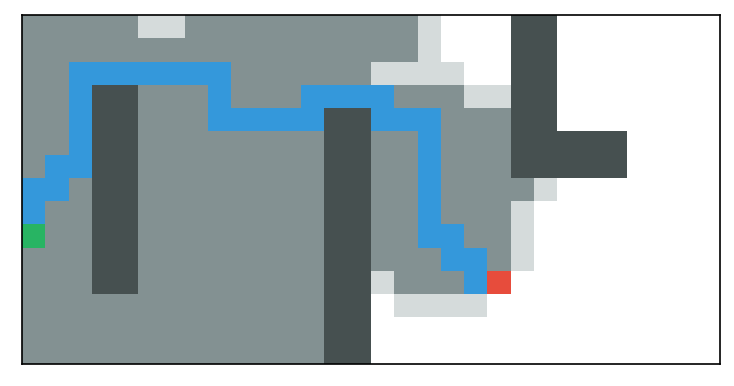

Path found! Length: 38. Nodes created: 864. Number of steps: 239. Correct: False


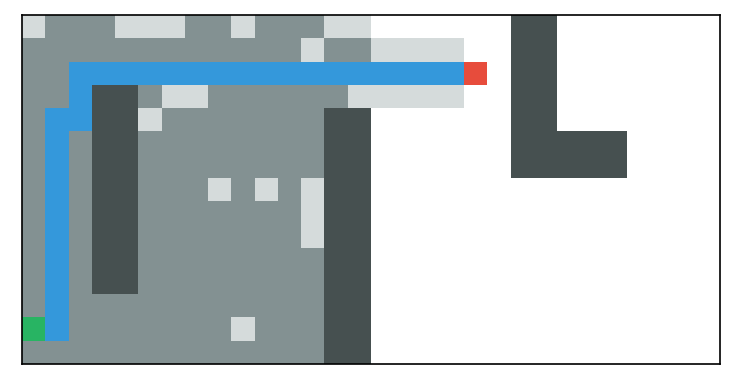

Path found! Length: 30. Nodes created: 620. Number of steps: 172. Correct: True


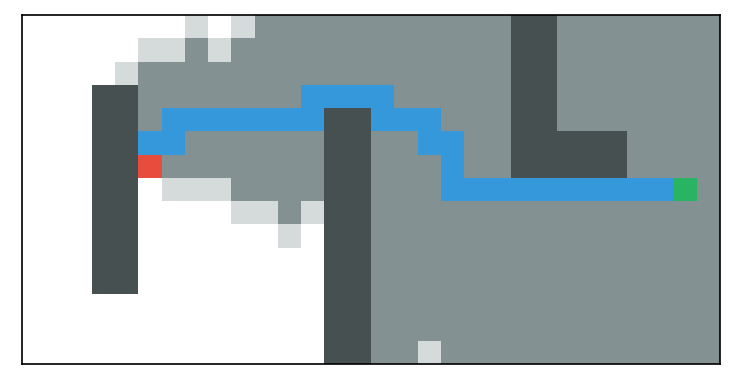

Path found! Length: 30. Nodes created: 968. Number of steps: 265. Correct: True


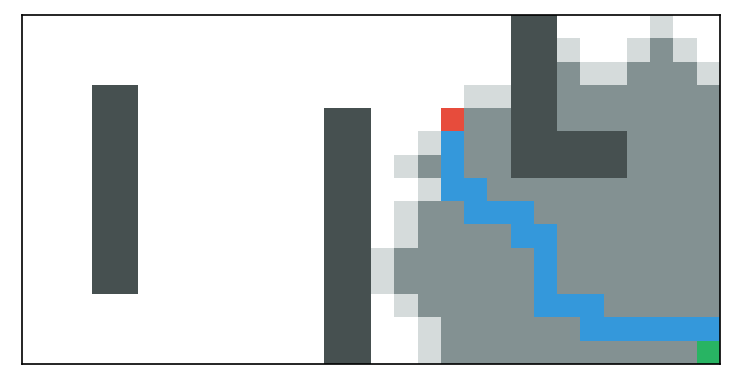

Path found! Length: 21. Nodes created: 517. Number of steps: 140. Correct: True


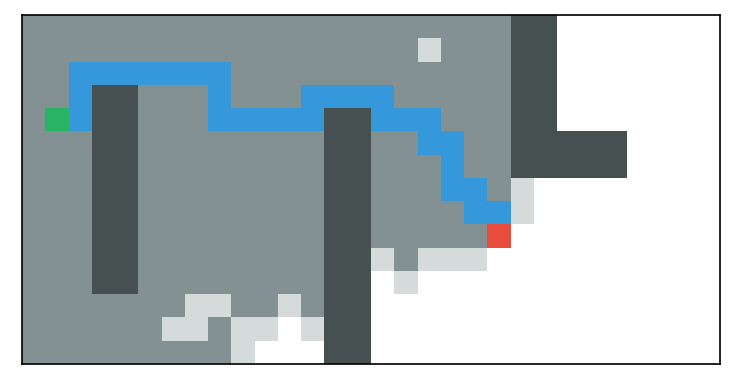

Path found! Length: 30. Nodes created: 834. Number of steps: 232. Correct: False


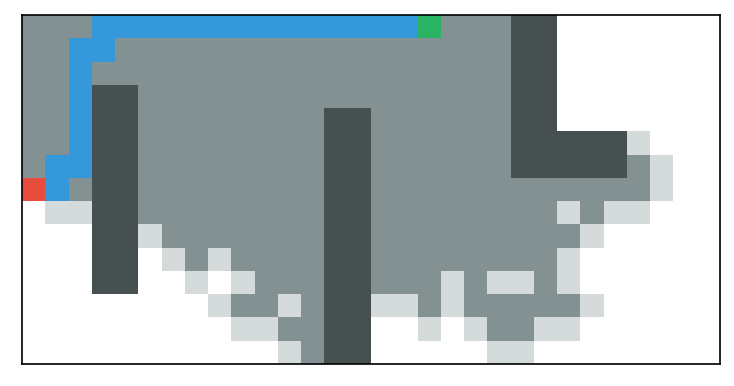

Path found! Length: 24. Nodes created: 821. Number of steps: 225. Correct: True


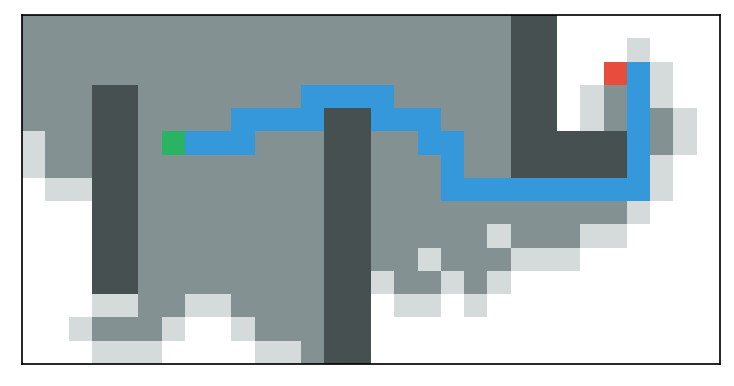

Path found! Length: 32. Nodes created: 852. Number of steps: 233. Correct: True


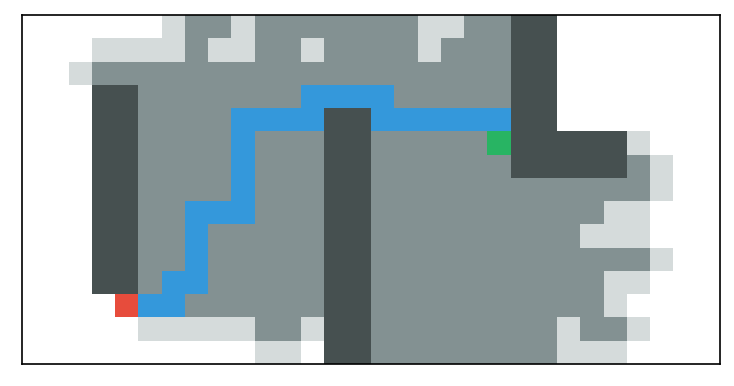

Path found! Length: 27. Nodes created: 852. Number of steps: 230. Correct: True


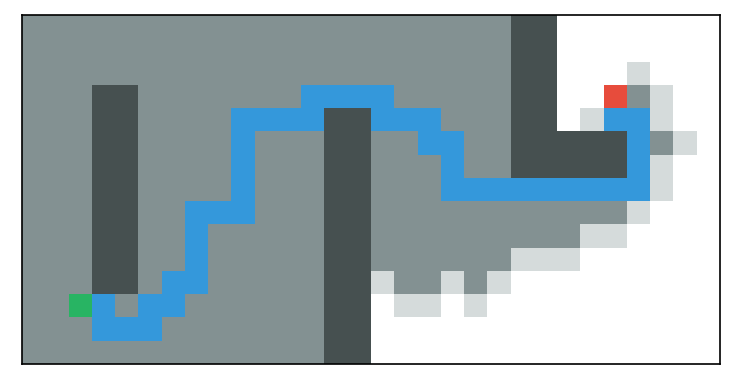

Path found! Length: 44. Nodes created: 991. Number of steps: 275. Correct: False


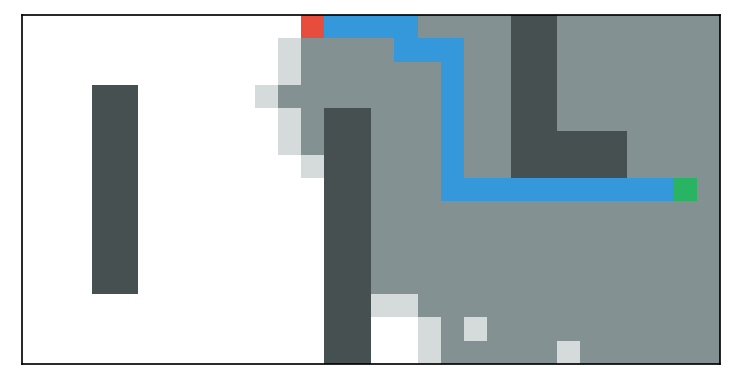

Path found! Length: 23. Nodes created: 762. Number of steps: 210. Correct: True


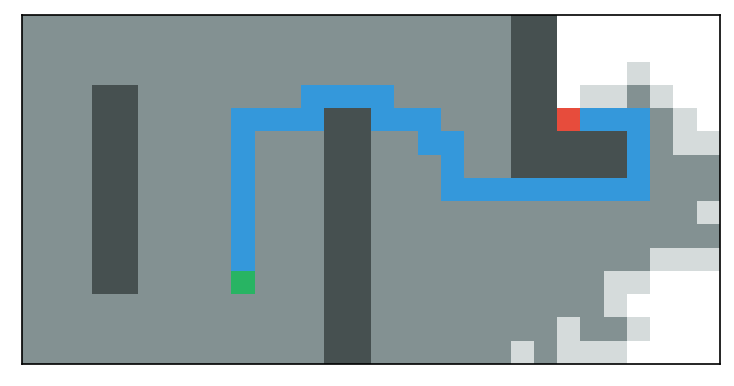

Path found! Length: 35. Nodes created: 1204. Number of steps: 332. Correct: True


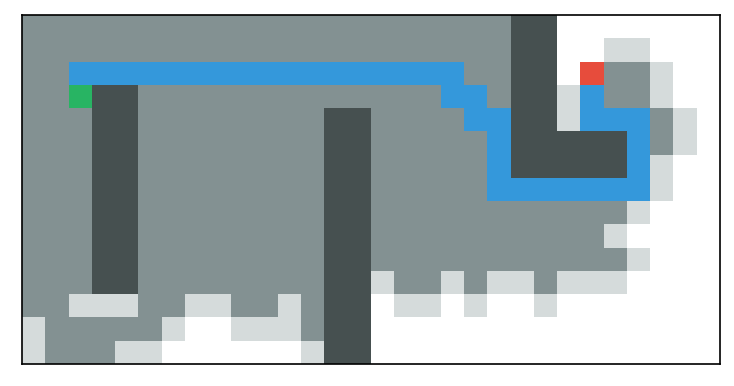

Path found! Length: 37. Nodes created: 965. Number of steps: 265. Correct: True


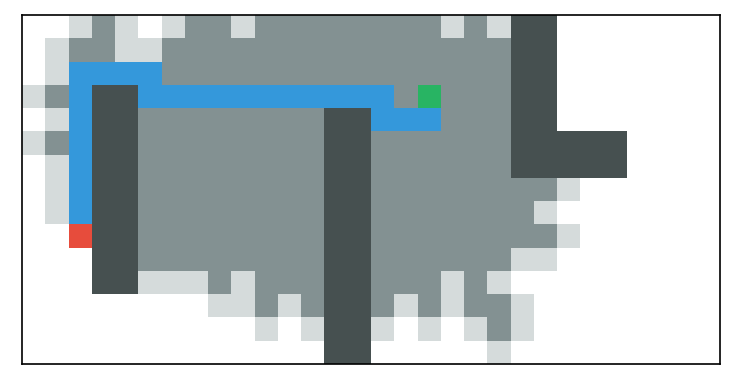

Path found! Length: 25. Nodes created: 705. Number of steps: 191. Correct: False


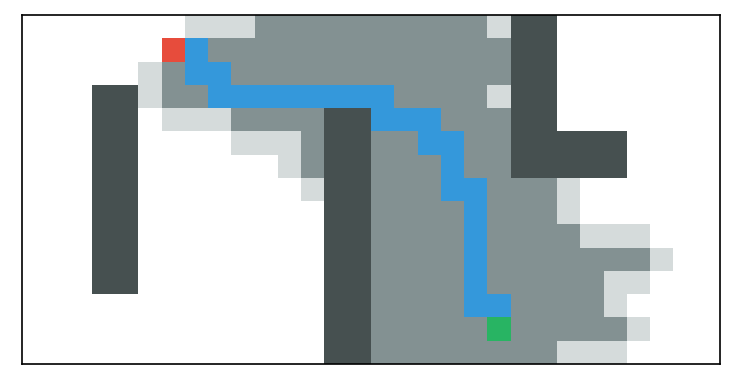

Path found! Length: 26. Nodes created: 572. Number of steps: 154. Correct: True


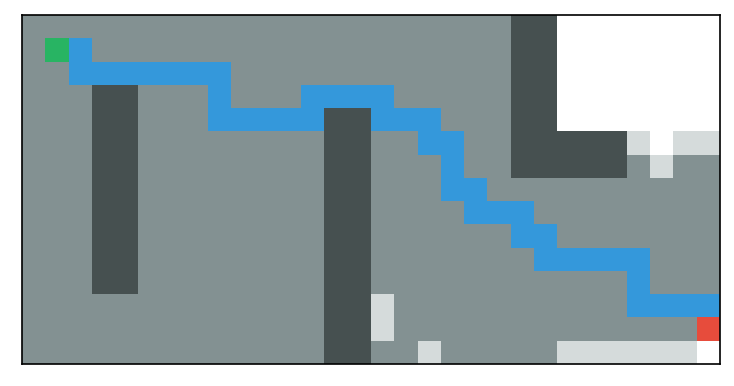

Path found! Length: 42. Nodes created: 1237. Number of steps: 340. Correct: False


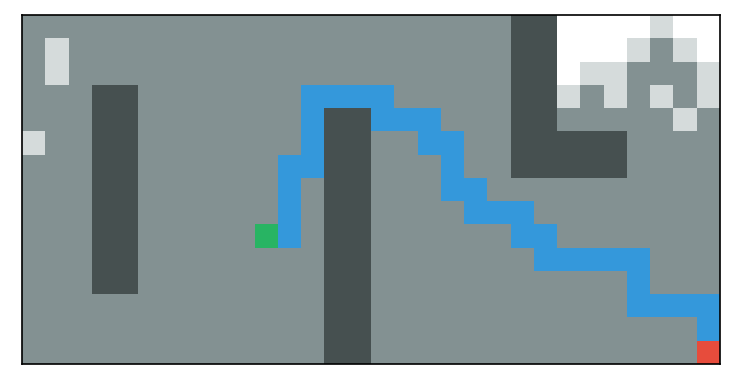

Path found! Length: 36. Nodes created: 1321. Number of steps: 365. Correct: True


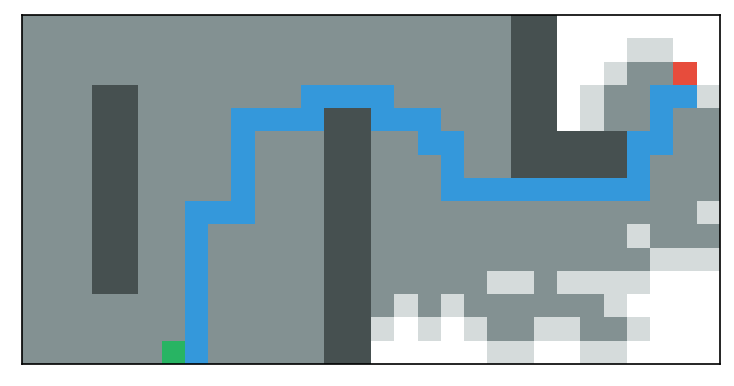

Path found! Length: 42. Nodes created: 1164. Number of steps: 320. Correct: True


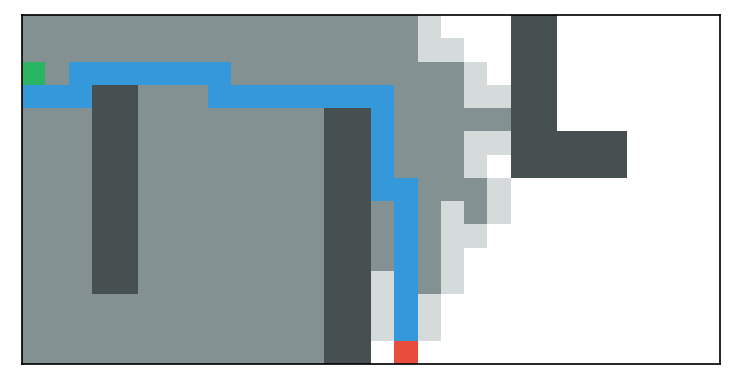

Path found! Length: 30. Nodes created: 833. Number of steps: 231. Correct: False


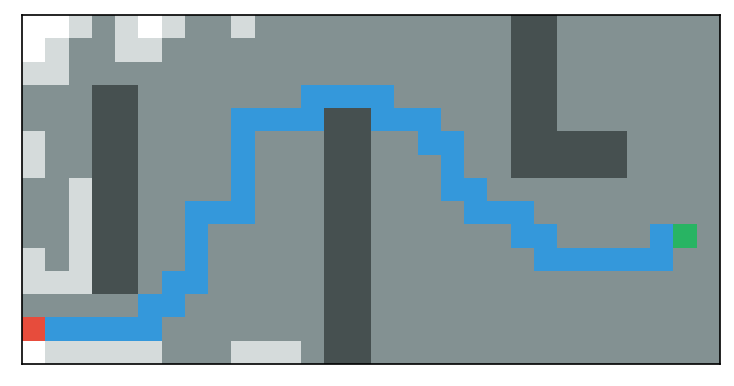

Path found! Length: 46. Nodes created: 1305. Number of steps: 358. Correct: False


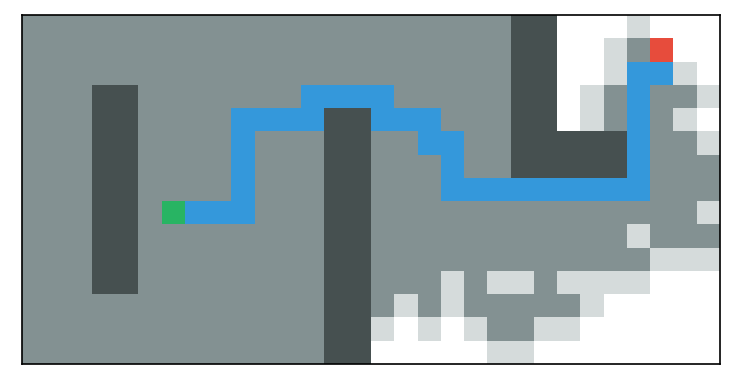

Path found! Length: 36. Nodes created: 1142. Number of steps: 314. Correct: True


In [18]:
for i in range(20):
    simple_test(astar, i, inconsistent_heuristic, YourOpen, YourClosed)

## A* Algorithm With Reexpansion

In [19]:
class OpenAndClosedBase:

    def __init__(self):
        pass
    
    def __iter__(self):
        pass
    
    def __len__(self):
        pass

    def is_empty(self):
        '''
        is_empty should inform whether the container is exhausted or not in the former case the search main loop should be interrupted
        '''
        pass

    def add_node(self, item):
        '''
        add_node is the method that puts (e.g. inserts or updates) the node to container
        '''
        pass

    def get_best_node(self):
        '''
        get_best_node is the method that finds the best node, i.e. the one with the lowest f-value (f = g + h) (for Dijkstra h = 0) and returns it
        '''
        pass
    
    @property
    def expanded(self):
        '''
        expanded is the method that finds all cells, which were expanded at least one time and returns iterable collection of relevant nodes
        '''
        pass
    
    @property
    def reexpanded(self):
        '''
        reexpanded is the method that finds all cells, which were expanded more than one time and returns iterable collection of relevant nodes
        '''
        pass

    @property
    def number_of_reexpansions(self):
        '''
        The method returns the total number of reexpansions of cells (with repeated reexpansions)
        '''
        pass


In [20]:
class YourOpenAndClosed (OpenAndClosedBase):

    def __init__(self):
        self.heap = []
        self.expanded_nodes = {}
        self.reexpanded_nodes = {}
        self.reexp_count = 0

    def __iter__(self):
        return iter(self.heap)
    
    def __len__(self):
        return len(self.heap)

    def is_empty(self):
        return len(self.heap) == 0

    def add_node(self, item):
        pos = item.get_pos()
        if pos in self.expanded_nodes:
            if self.expanded_nodes[pos].g <= item.g:
                return
            self.reexpanded_nodes[pos] = item
            self.reexp_count += 1
            del self.expanded_nodes[pos]
        heapq.heappush(self.heap, item)

    def get_best_node(self):
        while True:
            best = self.heap[0]
            pos = best.get_pos()
            heapq.heappop(self.heap)
            if pos not in self.expanded_nodes:
                break
        self.expanded_nodes[pos] = best
        return best

    @property
    def expanded(self):
        return self.expanded_nodes.values()

    @property
    def reexpanded(self):
        return self.reexpanded_nodes.values()

    @property
    def number_of_reexpansions(self):
        return self.reexp_count


In [21]:
def astar_reexpansion(grid_map: Map, start_i, start_j, goal_i, goal_j, heuristic_func = None, open_and_closed_type = YourOpenAndClosed):

    OPEN_AND_CLOSED = open_and_closed_type()
    steps = 0
    nodes_created = 0
    h = heuristic_func(start_i, start_j, goal_i, goal_j)
    OPEN_AND_CLOSED.add_node(Node(start_i, start_j, h=h))
    nodes_created += 1

    while not OPEN_AND_CLOSED.is_empty():
        steps += 1
        v = OPEN_AND_CLOSED.get_best_node()
        if v.get_pos() == (goal_i, goal_j):
            return True, v, steps, nodes_created, OPEN_AND_CLOSED, OPEN_AND_CLOSED.expanded, OPEN_AND_CLOSED.reexpanded
        for nxt_i, nxt_j in grid_map.get_neighbors(v.i, v.j):
            cost = compute_cost(v.i, v.j, nxt_i, nxt_j)
            h = heuristic_func(nxt_i, nxt_j, goal_i, goal_j)
            nxt_node = Node(nxt_i, nxt_j, v.g + cost, h, parent=v)
            nodes_created += 1
            OPEN_AND_CLOSED.add_node(nxt_node)

    return (False, None, steps, nodes_created, OPEN_AND_CLOSED, OPEN_AND_CLOSED.expanded, OPEN_AND_CLOSED.reexpanded)


### Test with consistent heuristic function

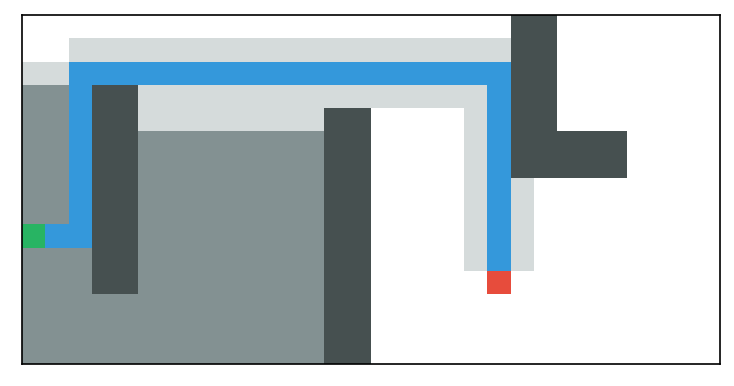

Path found! Length: 36. Nodes created: 537. Number of steps: 150. Correct: True
Number of reexpansions: 0


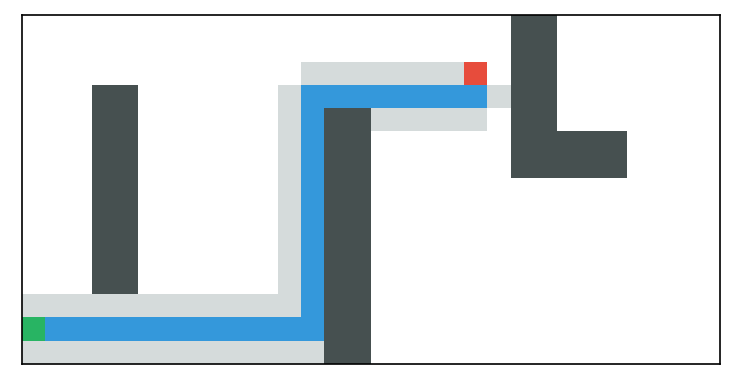

Path found! Length: 30. Nodes created: 108. Number of steps: 31. Correct: True
Number of reexpansions: 0


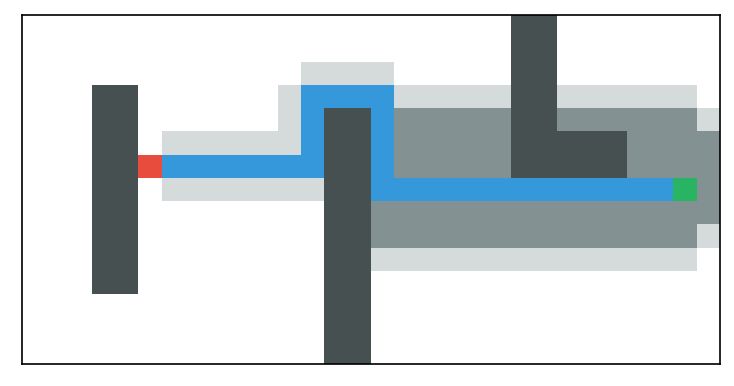

Path found! Length: 30. Nodes created: 328. Number of steps: 90. Correct: True
Number of reexpansions: 0


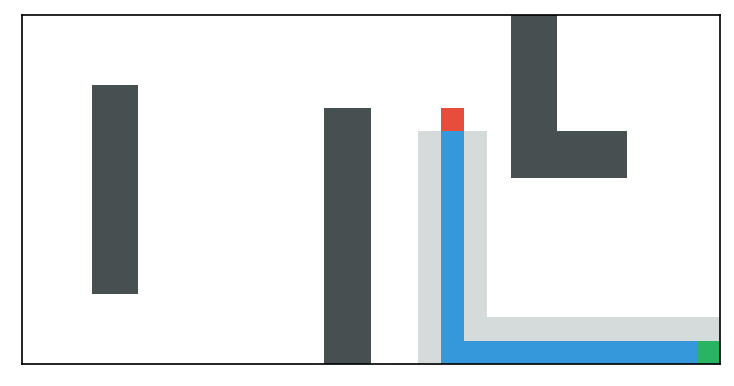

Path found! Length: 21. Nodes created: 72. Number of steps: 22. Correct: True
Number of reexpansions: 0


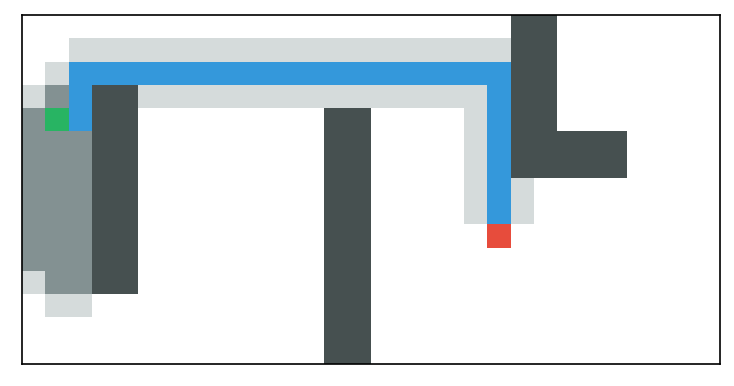

Path found! Length: 28. Nodes created: 178. Number of steps: 51. Correct: True
Number of reexpansions: 0


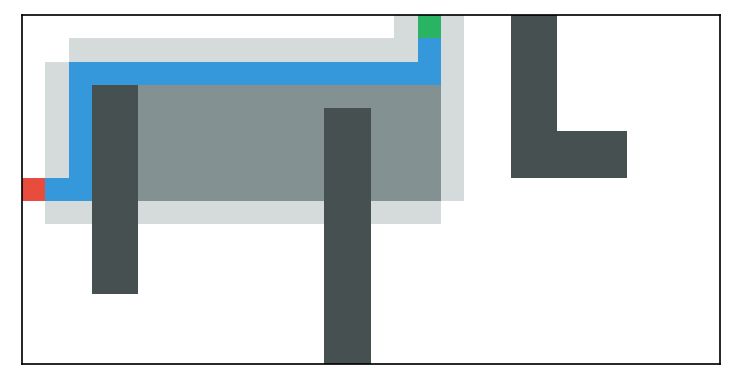

Path found! Length: 24. Nodes created: 302. Number of steps: 82. Correct: True
Number of reexpansions: 0


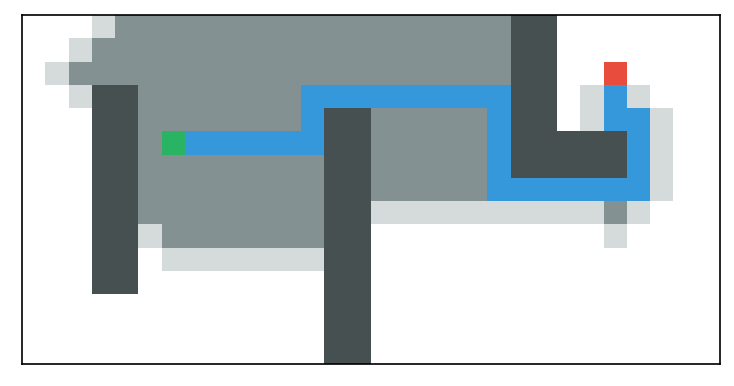

Path found! Length: 32. Nodes created: 561. Number of steps: 154. Correct: True
Number of reexpansions: 0


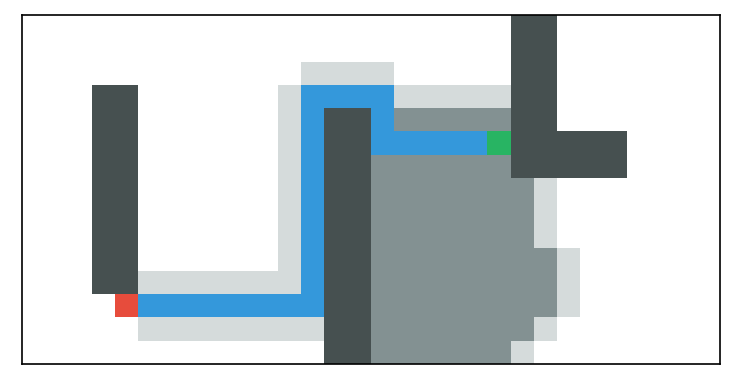

Path found! Length: 27. Nodes created: 353. Number of steps: 97. Correct: True
Number of reexpansions: 0


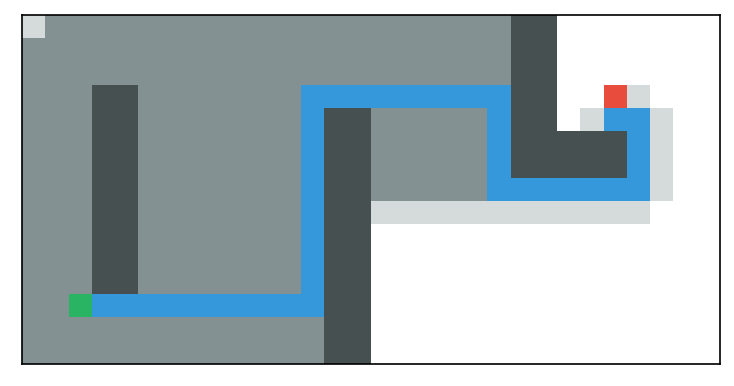

Path found! Length: 42. Nodes created: 868. Number of steps: 243. Correct: True
Number of reexpansions: 0


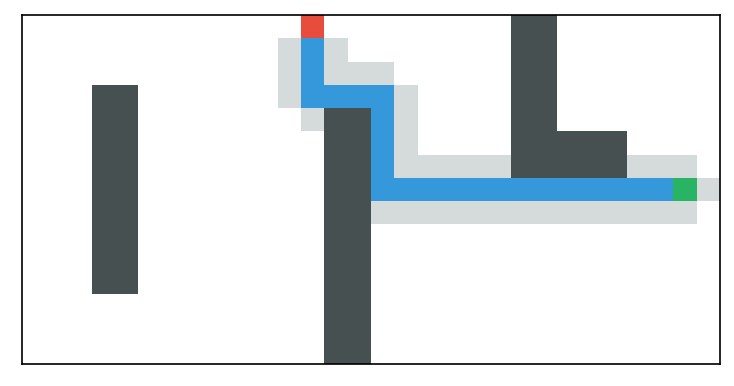

Path found! Length: 23. Nodes created: 82. Number of steps: 24. Correct: True
Number of reexpansions: 0


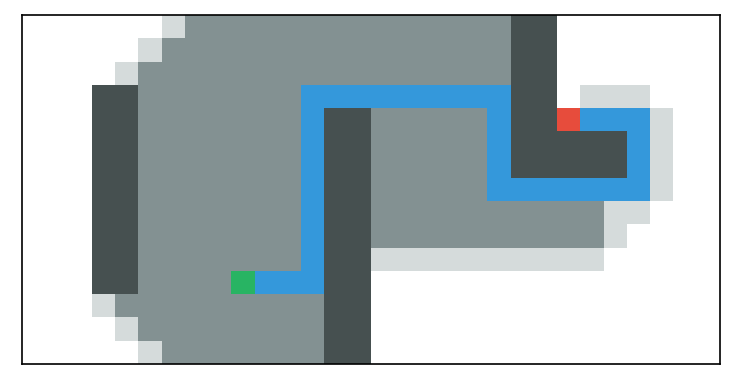

Path found! Length: 35. Nodes created: 751. Number of steps: 205. Correct: True
Number of reexpansions: 0


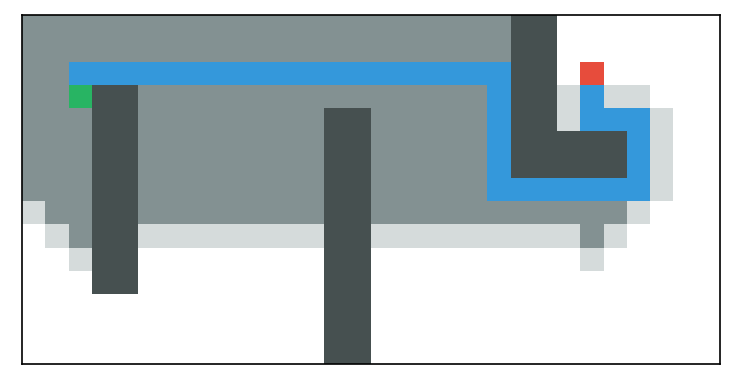

Path found! Length: 37. Nodes created: 669. Number of steps: 186. Correct: True
Number of reexpansions: 0


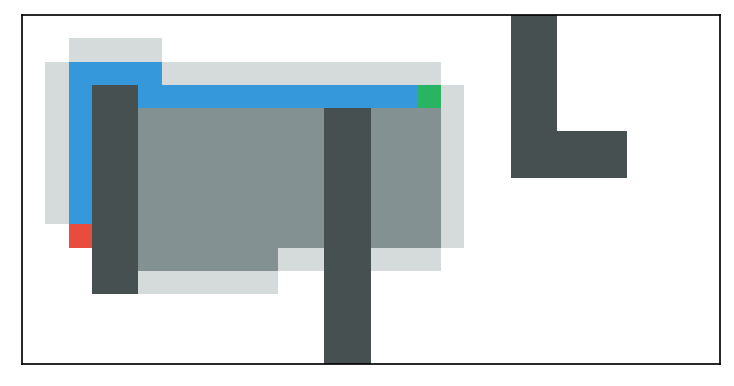

Path found! Length: 23. Nodes created: 351. Number of steps: 96. Correct: True
Number of reexpansions: 0


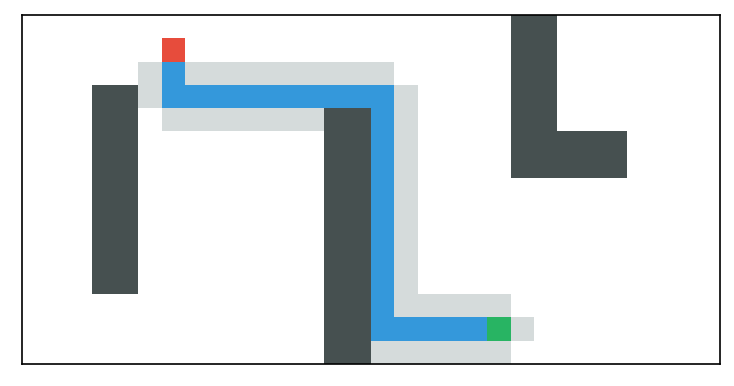

Path found! Length: 26. Nodes created: 93. Number of steps: 27. Correct: True
Number of reexpansions: 0


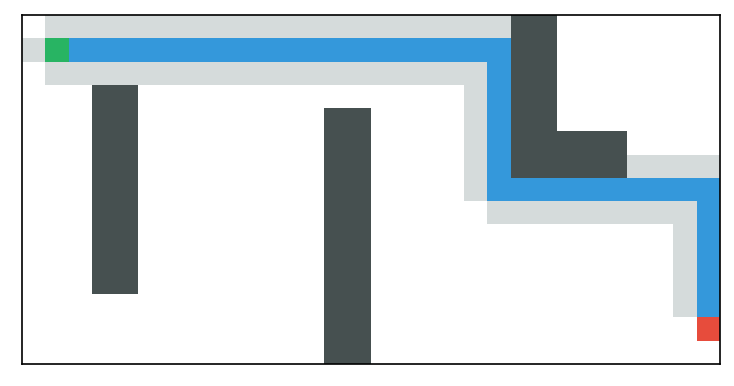

Path found! Length: 40. Nodes created: 144. Number of steps: 41. Correct: True
Number of reexpansions: 0


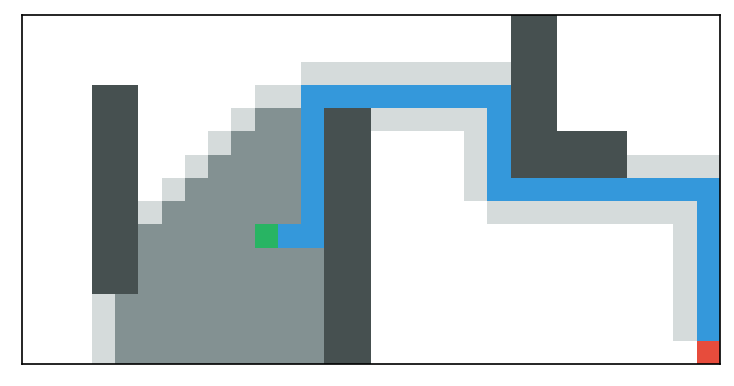

Path found! Length: 36. Nodes created: 375. Number of steps: 105. Correct: True
Number of reexpansions: 0


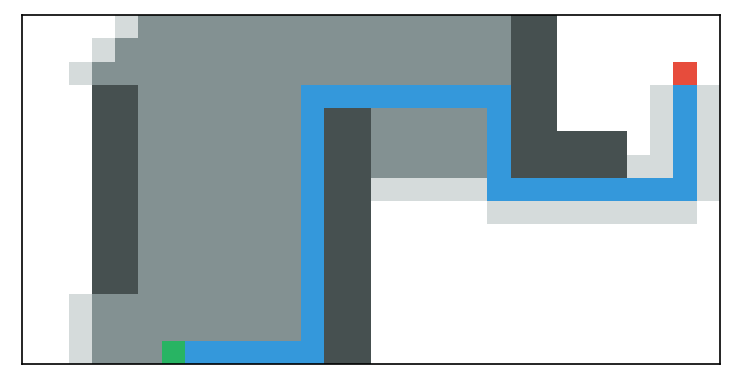

Path found! Length: 42. Nodes created: 702. Number of steps: 193. Correct: True
Number of reexpansions: 0


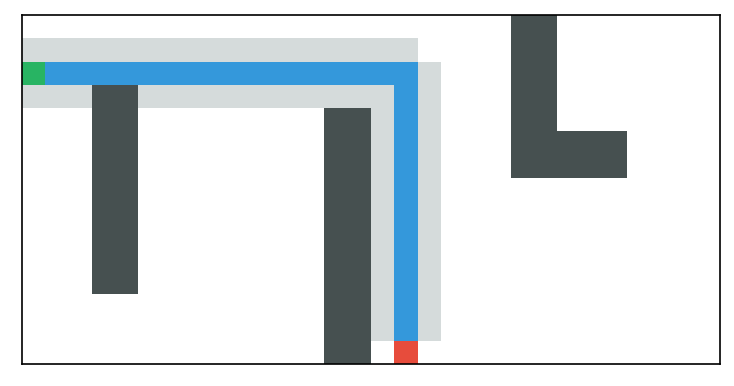

Path found! Length: 28. Nodes created: 110. Number of steps: 29. Correct: True
Number of reexpansions: 0


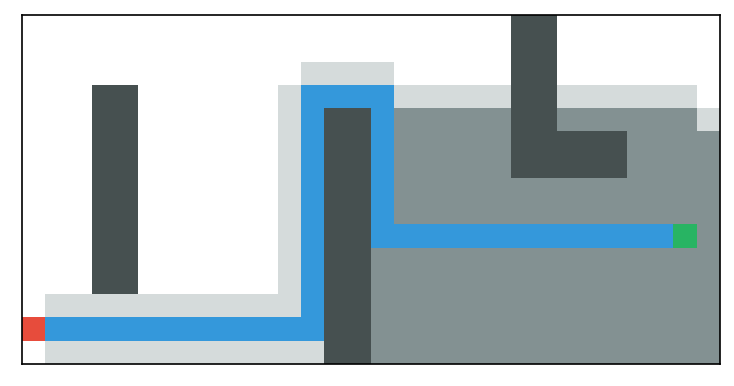

Path found! Length: 44. Nodes created: 647. Number of steps: 178. Correct: True
Number of reexpansions: 0


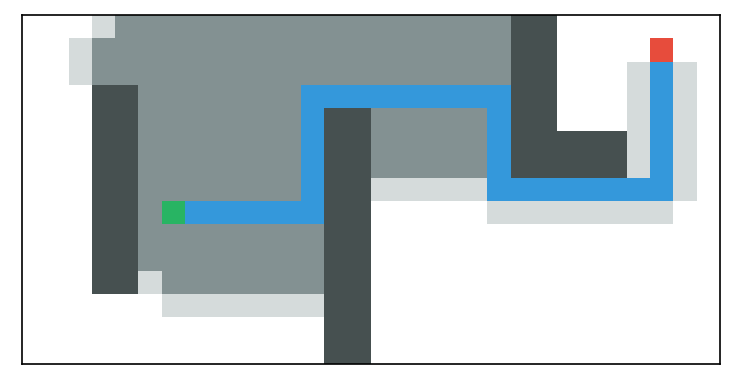

Path found! Length: 36. Nodes created: 601. Number of steps: 164. Correct: True
Number of reexpansions: 0


In [22]:
for i in range(20):
    res = simple_test(astar_reexpansion, i, manhattan_distance, YourOpenAndClosed)
    print("Number of reexpansions:", res[4].number_of_reexpansions)

### Test with inconsistent heuristic function

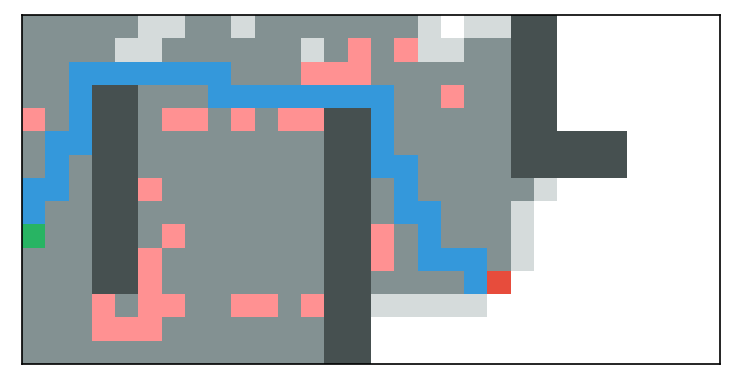

Path found! Length: 36. Nodes created: 1000. Number of steps: 276. Correct: True
Number of reexpansions: 30


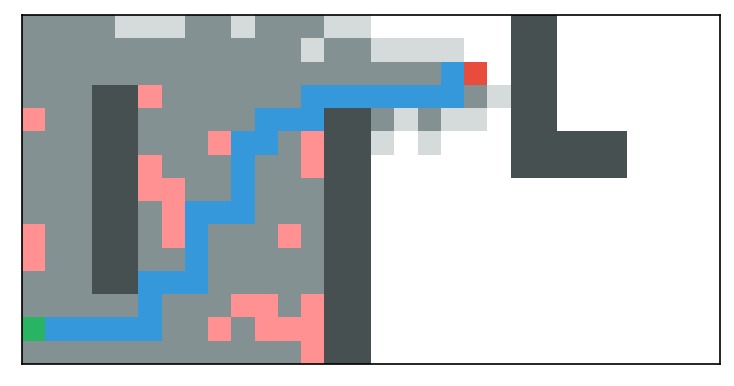

Path found! Length: 30. Nodes created: 774. Number of steps: 216. Correct: True
Number of reexpansions: 26


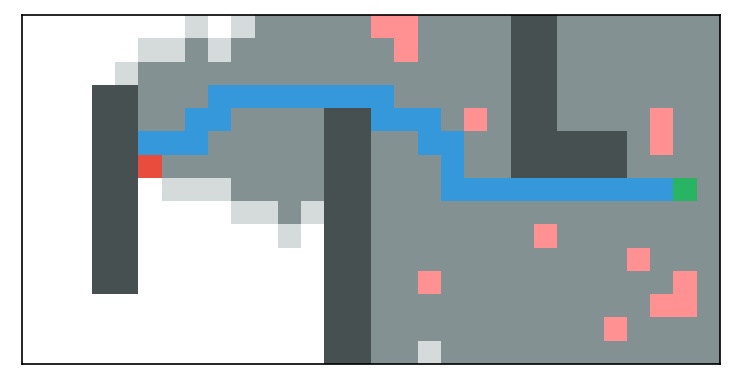

Path found! Length: 30. Nodes created: 1021. Number of steps: 279. Correct: True
Number of reexpansions: 14


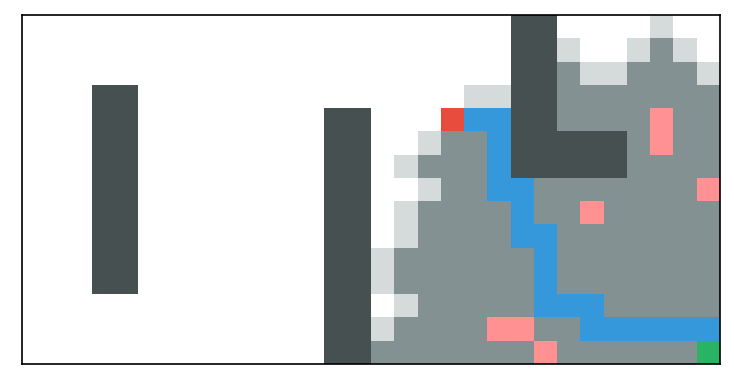

Path found! Length: 21. Nodes created: 559. Number of steps: 152. Correct: True
Number of reexpansions: 7


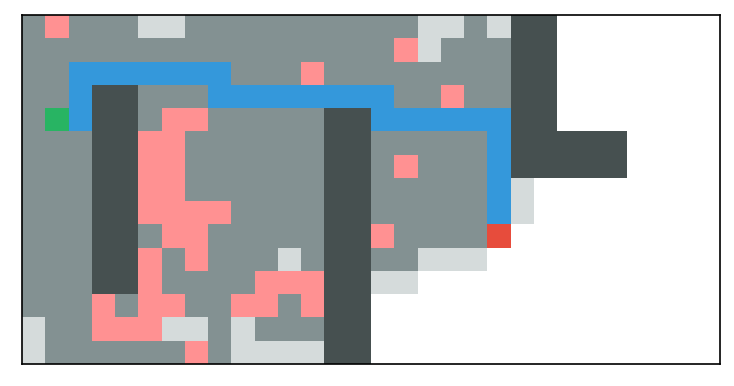

Path found! Length: 28. Nodes created: 998. Number of steps: 275. Correct: True
Number of reexpansions: 44


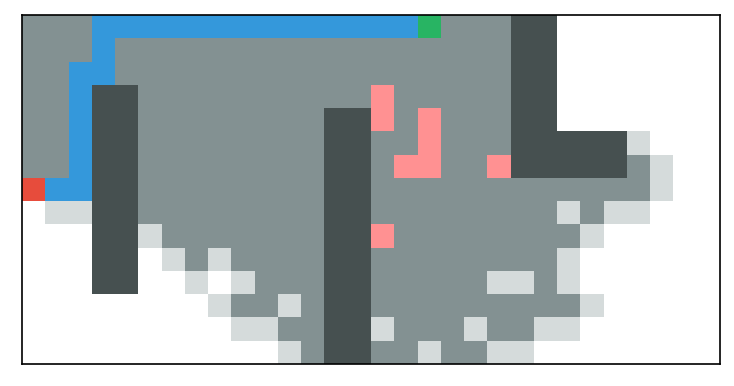

Path found! Length: 24. Nodes created: 888. Number of steps: 244. Correct: True
Number of reexpansions: 8


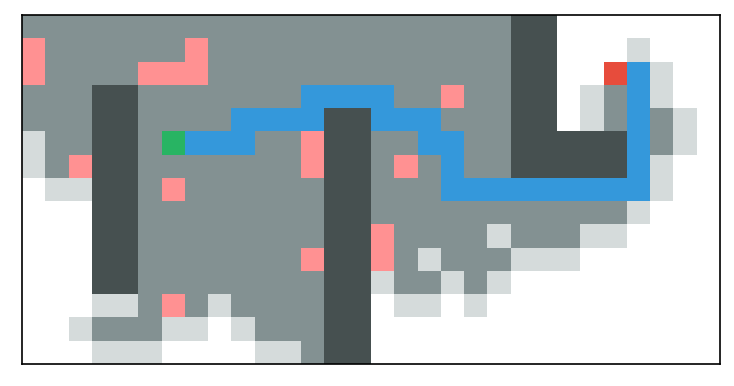

Path found! Length: 32. Nodes created: 912. Number of steps: 250. Correct: True
Number of reexpansions: 16


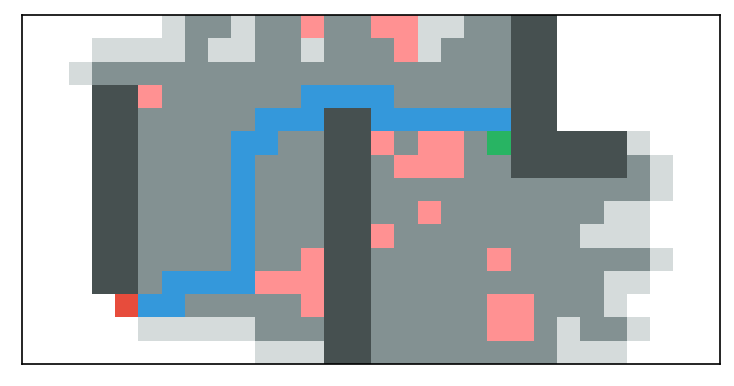

Path found! Length: 27. Nodes created: 949. Number of steps: 257. Correct: True
Number of reexpansions: 26


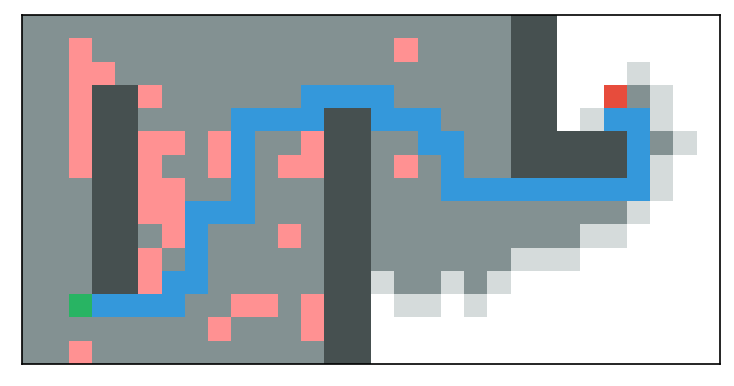

Path found! Length: 42. Nodes created: 1120. Number of steps: 312. Correct: True
Number of reexpansions: 37


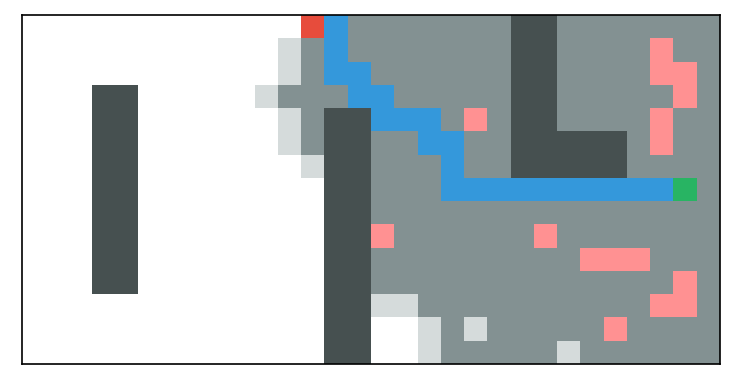

Path found! Length: 23. Nodes created: 825. Number of steps: 226. Correct: True
Number of reexpansions: 16


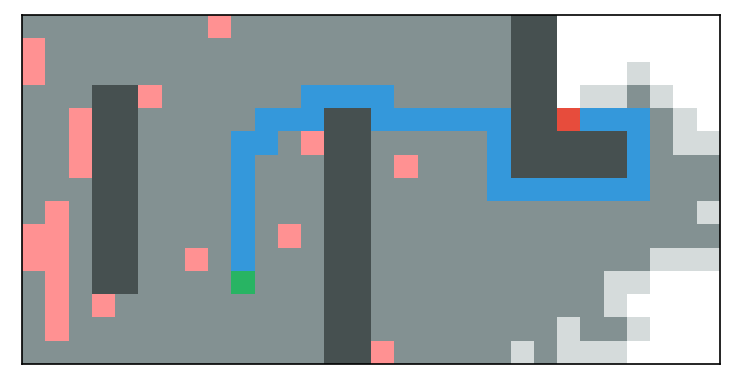

Path found! Length: 35. Nodes created: 1279. Number of steps: 354. Correct: True
Number of reexpansions: 22


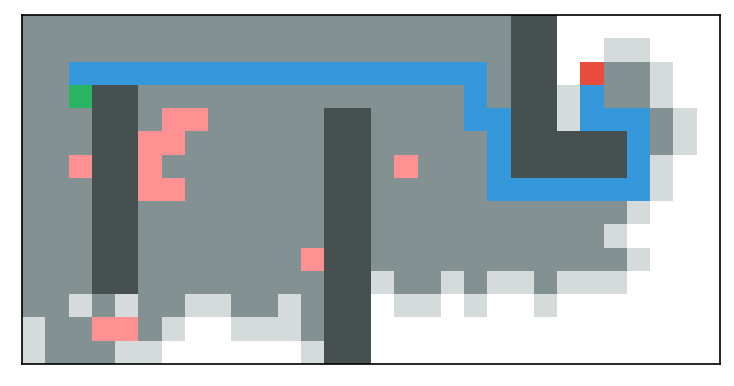

Path found! Length: 37. Nodes created: 1015. Number of steps: 279. Correct: True
Number of reexpansions: 13


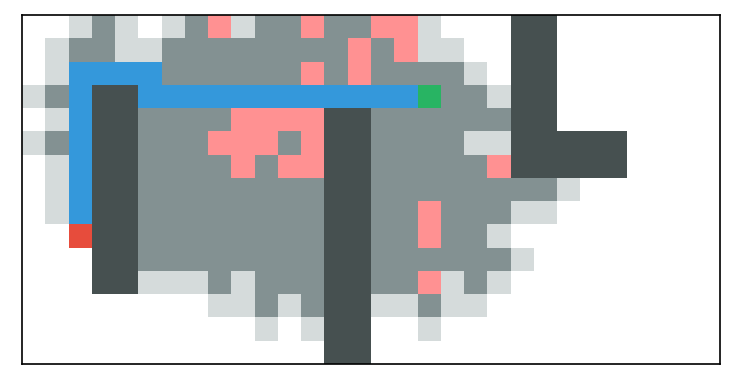

Path found! Length: 23. Nodes created: 745. Number of steps: 202. Correct: True
Number of reexpansions: 30


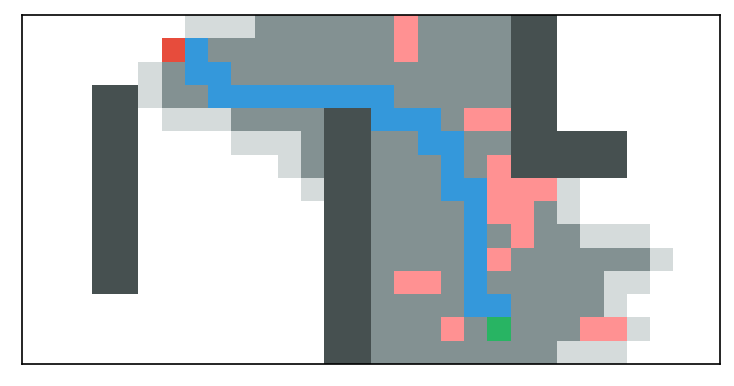

Path found! Length: 26. Nodes created: 640. Number of steps: 173. Correct: True
Number of reexpansions: 17


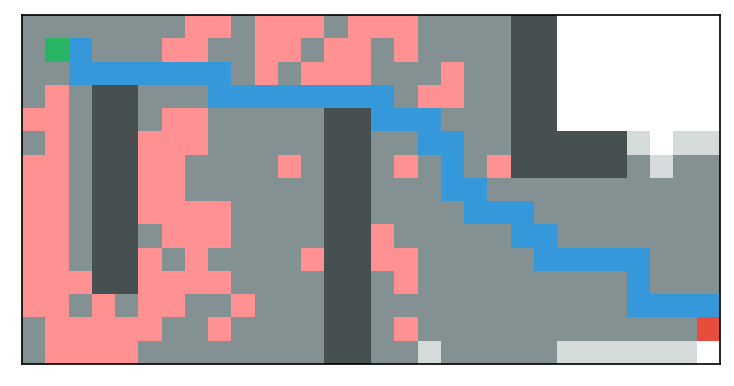

Path found! Length: 40. Nodes created: 1672. Number of steps: 460. Correct: True
Number of reexpansions: 118


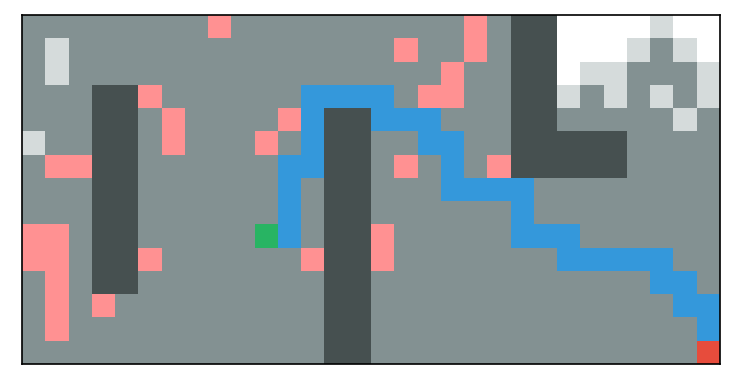

Path found! Length: 36. Nodes created: 1425. Number of steps: 394. Correct: True
Number of reexpansions: 29


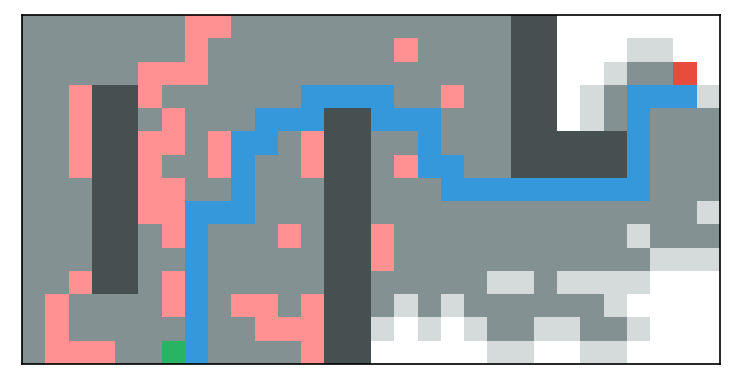

Path found! Length: 42. Nodes created: 1334. Number of steps: 369. Correct: True
Number of reexpansions: 49


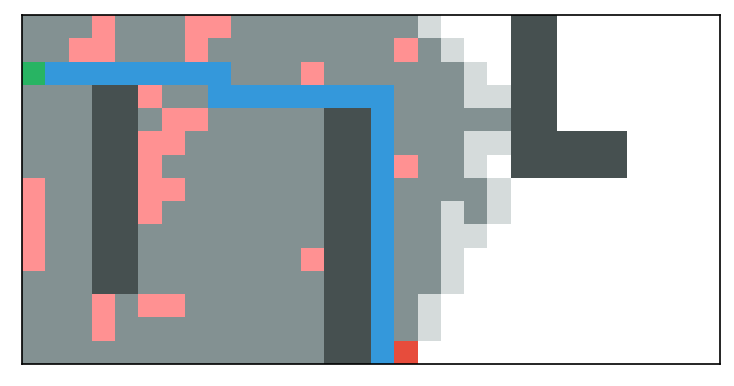

Path found! Length: 28. Nodes created: 992. Number of steps: 277. Correct: True
Number of reexpansions: 41


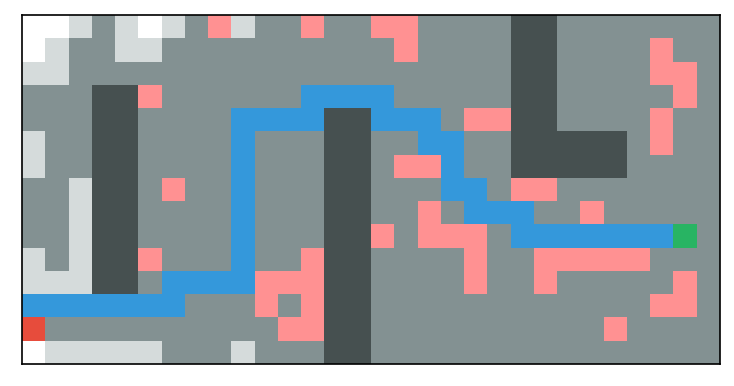

Path found! Length: 44. Nodes created: 1557. Number of steps: 426. Correct: True
Number of reexpansions: 66


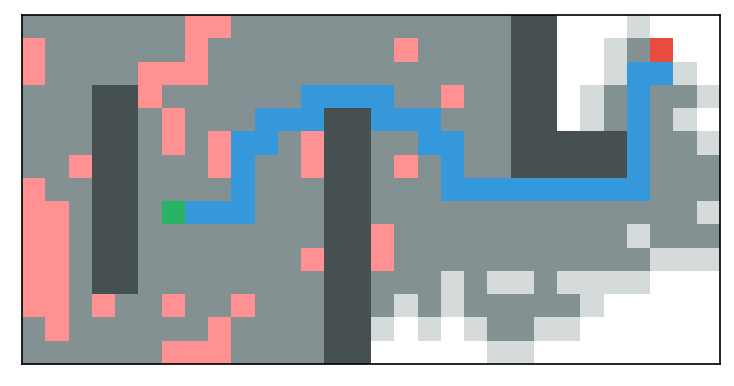

Path found! Length: 36. Nodes created: 1301. Number of steps: 359. Correct: True
Number of reexpansions: 45


In [23]:
for i in range(20):
    res = simple_test(astar_reexpansion, i, inconsistent_heuristic, YourOpenAndClosed)
    print("Number of reexpansions:", res[4].number_of_reexpansions)